<a href="https://colab.research.google.com/github/NadaAdelMousa/NLP_Tweets_Hate_Speech/blob/main/Lab_2_Text_Classification_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**The same task as Lab 1 except using `Word Embeddings OR RNNs`**

**Watch out!<br>
Preproceesing here is a a bit different<br>
Just take the cleaned data from the previous lab and cont...**


**Dataset**
labeled datasset collected from twitter

**Objective**
classify tweets containing hate speech from other tweets.
0 -> no hate speech
1 -> contains hate speech

**Total Estimated Time = 60 Mins**

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load Dataset

In [2]:
!gdown https://drive.google.com/uc?id=1BNcVdg2ByP1yvEL8UOeXeFHvAgyowjC1 -O dataset.csv

Downloading...
From: https://drive.google.com/uc?id=1BNcVdg2ByP1yvEL8UOeXeFHvAgyowjC1
To: /content/dataset.csv
100% 2.33M/2.33M [00:00<00:00, 112MB/s]


In [3]:
df = pd.read_csv('dataset.csv')
df.head()

,Unnamed: 0,tweets,label
0,0,when a father be dysfunctional and be so selfi...,0.0
1,1,thank for lyft credit i cant use cause they do...,0.0
2,2,bihday your majesty,0.0
3,3,model i love u take with u all the time in ur,0.0
4,4,factsguide society now motivation,0.0


In [4]:
train_text = df['tweets'].values.astype('str')
labels = df['label'].values.astype('float32')

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = \
     train_test_split(train_text, labels, test_size=.2, stratify=labels, random_state=42)

In [6]:
print(len(x_train))
print(len(x_val))

23624
5906


### Preprocessing


In [7]:
from keras.preprocessing.text import Tokenizer
vocab_sz = 20000
tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')
tok.fit_on_texts(x_train)

In [8]:
x_train_tok = tok.texts_to_sequences(x_train)
x_val_tok = tok.texts_to_sequences(x_val)

In [9]:
print(x_train_tok[0])
print(y_train[0])

[33, 530, 214, 460, 10, 49, 20, 878, 766, 18, 2, 175, 1259, 3512, 5]
0.0


In [10]:
words = list(tok.word_index.keys())[:vocab_sz+1]
dictt = dict(zip(words, range(1,len(words))))
len(dictt)

20000

### Modelling
**Use any Advanced technique such as: word2vec, glove, RNNs ... etc**

####Trainable Embedding layer RNN 

In [12]:
tweet_len = np.zeros(len(x_train_tok))
for v in range(len(x_train_tok)):
    tweet_len[v] = len(x_train_tok[v])

(array([1566., 3340., 4695., 4940., 3676., 3475., 1316.,  500.,  109.,
           7.]),
 array([ 1. ,  4.2,  7.4, 10.6, 13.8, 17. , 20.2, 23.4, 26.6, 29.8, 33. ]),
 <a list of 10 Patch objects>)

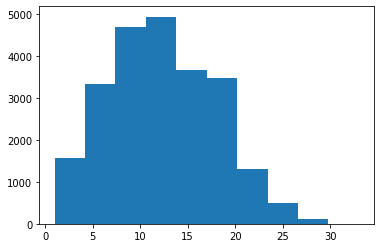

In [13]:
plt.hist(tweet_len)

In [11]:
from tensorflow.keras.preprocessing import sequence
x_train_emb = sequence.pad_sequences(x_train_tok, maxlen=30, padding='post')
x_val_emb = sequence.pad_sequences(x_val_tok, maxlen=30, padding='post')

In [40]:
x_train_emb[0]

array([  33,  530,  214,  460,   10,   49,   20,  878,  766,   18,    2,
        175, 1259, 3512,    5,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM, Bidirectional, GRU, Dropout

model = Sequential()
model.add(Embedding(vocab_sz, 128, mask_zero=True))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         1280000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 200)              183200    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                                 
Total params: 1,463,401
Trainable params: 1,463,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [ ]:
from keras.callbacks import EarlyStopping

checkpoint = EarlyStopping(monitor='val_acc', mode='max')
callbacks_lst = [checkpoint]

history = model.fit(x_train_emb, y_train,
          batch_size=32,
          epochs=10,
          validation_data=(x_val_emb, y_val),
          callbacks=callbacks_lst)

Epoch 1/10
739/739 [==============================] - 68s 93ms/step - loss: 0.0032 - acc: 0.9991 - val_loss: 0.2869 - val_acc: 0.9577
Epoch 2/10
739/739 [==============================] - 66s 89ms/step - loss: 0.0019 - acc: 0.9995 - val_loss: 0.2812 - val_acc: 0.9600


#### Evaluation

In [ ]:
y_pred = model.predict(x_val_emb)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_pred,y_val))

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98      5567
         1.0       0.63      0.75      0.68       339

    accuracy                           0.96      5906
   macro avg       0.81      0.86      0.83      5906
weighted avg       0.96      0.96      0.96      5906



####GLoVe

In [1]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-07-07 12:46:18--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-07-07 12:46:18--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-07-07 12:46:19--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [88]:
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [89]:
num_tokens = vocab_sz + 1
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i  in dictt.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        print(word)
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Streaming output truncated to the last 5000 lines.
hinditayotao
thfloor
onelastpush
omegapsiphi
denzelwashington
morganfreeman
willsmith
marianorchard
baletebatangas
delasoul
oaoao
monbbsemasa
paradea
preconference
whoas
pumpedup
appleoneatshrm
plushie
fivenightsatfreddys
fnaf
plusha
bmark
sjsvspit
norespect
jabardasti
photosession
nikkhhil
framelements
daysoutwiththekids
myboys
bihdaycelebrations
mayyourheaopen
iowfestival
hotgirl
jovio
butthucreepers
feelinglucky
kewt
prettys
hunni
nbak
errythang
crapsac
weddingvenue
whaon
hindusena
messihas
messiha
instabeauty
peaceandcomfo
mypic
trocolikes
chaani
gonnabeepicmovie
datastrucutres
youtubera
musicday
thelifeistoosho
queensofsass
anow
kimiao
goodqualikimi
jeanalesi
canadagp
pvuorela
tagsforlike
haisl
pornhub
livepass
missedthegame
godogs
aadd
gradle
memyselfandisaiah
beardcrew
beardgamecrazy
beardgang
pointlifea
starfightersaturday
phantomaviation
wbruchal
mayrdom
dreamboys
babyshower
kosoko
mclarenhonda
cuckssuck
geminia
fbloggers
depo

In [90]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM, Bidirectional, GRU, Dropout
from tensorflow.keras.initializers import Constant

model = Sequential()
model.add(Embedding(num_tokens, embedding_dim, 
                    embeddings_initializer=Constant(embedding_matrix), 
                    trainable=True))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 100)         2000100   
                                                                 
 bidirectional_4 (Bidirectio  (None, 200)              160800    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 1)                 201       
                                                                 
Total params: 2,161,101
Trainable params: 2,161,101
Non-trainable params: 0
_________________________________________________________________


In [91]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [92]:
from keras.callbacks import EarlyStopping

checkpoint = EarlyStopping(monitor='val_acc', mode='max')
callbacks_lst = [checkpoint]

history = model.fit(x_train_emb, y_train,
          batch_size=32,
          epochs=10,
          validation_data=(x_val_emb, y_val),
          callbacks=callbacks_lst)

Epoch 1/10
739/739 [==============================] - 62s 79ms/step - loss: 0.1688 - acc: 0.9405 - val_loss: 0.1293 - val_acc: 0.9499
Epoch 2/10
739/739 [==============================] - 58s 79ms/step - loss: 0.1018 - acc: 0.9632 - val_loss: 0.1079 - val_acc: 0.9617


In [94]:
y_pred = model.predict(x_val_emb)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

In [95]:
from sklearn.metrics import classification_report
print(classification_report(y_pred,y_val))

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      5619
         1.0       0.58      0.81      0.67       287

    accuracy                           0.96      5906
   macro avg       0.78      0.89      0.83      5906
weighted avg       0.97      0.96      0.96      5906



####word2vec

In [11]:
import gensim.downloader

In [12]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [26]:
w2vec = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [34]:
num_tokens = vocab_sz + 1
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i  in dictt.items():
  try:
    embedding_vector = w2vec[word]
    embedding_matrix[i] = embedding_vector
    hits += 1
  except KeyError:
        print(word)
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Streaming output truncated to the last 5000 lines.
bestever
shropshire
contentedat
blessedat
inspiringwords
mybeaconoflight
menifeea
kinnock
instatest
stateofwomen
goodluckinnovember
matthewbellamy
mattbellamy
bihdaymattbellamy
downasquadmember
treeouts
twtly
boulderjewishfestival
clearlynooneslisteningtoyouropinions
greatfinds
globaldesi
unionville
clev
mrchoke
deephouse
techouse
sarajevo
bacca
comingsoona
vancitybuzza
motheranddaughter
blackandwhitephotohraphy
momentofhappinessa
timesnow
speno
aindiana
btcc
asaudi
sweepa
acnease
howlongtilseasa
geminis
godisgreat
ilooklikeiwasattacked
actilabs
everyonea
funkysummershowcase
dressrehearsal
itsthefinalcountdown
youngcarers
rctcbc
rctcouncil
rct
carersweek
porfinencasa
johor
costeaita
vacationsoff
byebali
kaiyak
libelle
annabeljones
topoli
lastword
yfmghana
realperson
littlea
trumpproofamerica
leb
maxiaretes
sugarray
storyville
soundslivefeelslivecologne
becarefull
inworda
germansandtheirbread
gonnagetkilled
sposday
sackrace
workinprogre

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM, Bidirectional, GRU, Dropout
from tensorflow.keras.initializers import Constant

model = Sequential()
model.add(Embedding(num_tokens, embedding_dim, 
                    embeddings_initializer=Constant(embedding_matrix), 
                    trainable=False))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         6000300   
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              320800    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 6,321,301
Trainable params: 321,001
Non-trainable params: 6,000,300
_________________________________________________________________


In [37]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [41]:
from keras.callbacks import EarlyStopping

checkpoint = EarlyStopping(monitor='val_acc', mode='max')
callbacks_lst = [checkpoint]

history = model.fit(x_train_emb, y_train,
          batch_size=32,
          epochs=10,
          validation_data=(x_val_emb, y_val),
          callbacks=callbacks_lst)

Epoch 1/10
739/739 [==============================] - 64s 81ms/step - loss: 0.1764 - acc: 0.9401 - val_loss: 0.1427 - val_acc: 0.9468
Epoch 2/10
739/739 [==============================] - 59s 79ms/step - loss: 0.1404 - acc: 0.9497 - val_loss: 0.1358 - val_acc: 0.9531


In [42]:
y_pred = model.predict(x_val_emb)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

In [43]:
from sklearn.metrics import classification_report
print(classification_report(y_pred,y_val))

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98      5630
         1.0       0.50      0.73      0.59       276

    accuracy                           0.95      5906
   macro avg       0.74      0.85      0.78      5906
weighted avg       0.96      0.95      0.96      5906



####using spacy

In [12]:
import spacy

In [ ]:
! python -m spacy download en_core_web_md

In [16]:
spacy_emb = spacy.load('en_core_web_md')

In [28]:
num_tokens = vocab_sz + 1
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i  in dictt.items():
    embedding_vector = spacy_emb(word).vector
    if embedding_vector.any()== True:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        print(word)
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Streaming output truncated to the last 5000 lines.
toomanyguns
stopcrueltytoanimals
sexpes
xdcct
marcorubio
supposystem
reproductiverights
bihcontrol
ontheblog
aplk
lapiso
diamondcastlejewelers
feelingblue
shufflelp
cousinben
multimillionairedad
musicshow
fridayy
helpfula
gloday
emani
goodriddance
believeinyou
neverstopa
kejungie
getbigger
djmac
underamour
fitnessfriday
grainne
semenbulletdrop
airraid
manstreet
dieresidents
iaiia
hereicome
drynuggets
blackcokwhiteass
gettingold
becomingboring
notborderlands
goblizzard
tahzan
innallaha
maana
brennank
wellybel
barharbor
soybu
nickis
debeloping
cebuph
kyleecharri
itneverstopshuing
kosie
likescam
inspirationmonday
allergyfree
alliesgfgoodies
wecarea
contactcenters
thirstdays
thoughtcast
whoknew
ageisjustanumber
gegenrechts
nostrache
noafd
nopegida
nonazis
aufstehn
aothat
hereao
funnygif
ojccrucwqzom
canadianstyle
smokeda
durraofficial
besttime
goodmorninga
benice
lostones
prayforflorida
selamatmalam
secretoflife
poppetmaster
giantsa
spaanb

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM, Bidirectional, GRU, Dropout
from tensorflow.keras.initializers import Constant

model = Sequential()
model.add(Embedding(num_tokens, embedding_dim, 
                    embeddings_initializer=Constant(embedding_matrix), 
                    trainable=False))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         6000300   
                                                                 
 bidirectional (Bidirectiona  (None, 200)              320800    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 6,321,301
Trainable params: 321,001
Non-trainable params: 6,000,300
_________________________________________________________________


In [31]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [32]:
from keras.callbacks import EarlyStopping

checkpoint = EarlyStopping(monitor='val_acc', mode='max')
callbacks_lst = [checkpoint]

history = model.fit(x_train_emb, y_train,
          batch_size=32,
          epochs=10,
          validation_data=(x_val_emb, y_val),
          callbacks=callbacks_lst)

Epoch 1/10
739/739 [==============================] - 72s 92ms/step - loss: 0.1876 - acc: 0.9374 - val_loss: 0.1588 - val_acc: 0.9445
Epoch 2/10
739/739 [==============================] - 67s 90ms/step - loss: 0.1501 - acc: 0.9472 - val_loss: 0.1453 - val_acc: 0.9524


In [33]:
y_pred = model.predict(x_val_emb)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_pred,y_val))

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97      5618
         1.0       0.51      0.71      0.59       288

    accuracy                           0.95      5906
   macro avg       0.75      0.84      0.78      5906
weighted avg       0.96      0.95      0.96      5906



#### Done!